## Rotating coil calibration in a Reference Quadrupole

In [1]:
import numpy as np
import pandas as pd
from sympy import *
#from IPython.display import Latex
import scipy
init_printing(True)

In [2]:
# Defining Variables
An, Bn, Cn, i = symbols('A_n B_n C_n i')
Za, Zb, C2, C1, d = symbols('z_a z_b C_2 C_1 d')
delta_c1, psi_1, psi_2, kappa_n = symbols('Delta_C_1 Psi_1 Psi_2 kappa_n')
Rref, R, R1, R2 = symbols('R_ref R R_1 R_2')
Nt, N, W, n = symbols('N_t N W n')
L, delta_x, delta_psi1, delta_z = symbols('L Delta_x Delta_Psi_1 Delta_z')

## Definitions

In [3]:
_harmonic_Cn = Eq(Cn, Bn+i*An)
_raio_eq = Eq(R,(d*abs(C2*(Za))/(abs(delta_c1))))
_sensitivity_coil = Eq(kappa_n, (Nt*L/n)*(R2**2-R1**2))
_raio_psi = Eq(R,-(psi_2*delta_x)/delta_psi1)
Dz = Eq(delta_z, -Rref*(C1/C2))

#### Field Coefficients Cn n-harmonics

In [4]:
_harmonic_Cn

#### Equivalent Radius R by Quadrupolar a nd Dipolar Field Coefficients (C2 and C1)

In [5]:
_raio_eq

#### Coefficients of coil geometrical calibration (“sensitivity factors”) for a Radial Coil

In [6]:
_sensitivity_coil

#### Equivalent Radius R by Fast Fourier Transforms FFTs

In [7]:
_raio_psi

#### Displacement by a translation of the coil with respect to the magnet frame

In [8]:
Dz

#### Integrated Harmonics and FFT data collected from Rotating Coil Software for each of the transverse positions

In [9]:
#Integrated Harmonics and FFT data collected from Rotating Coil Software

_data = {'Align X[m]':[1.90E-06, 3.10E-03, 5.11E-03, 7.10E-03], #Transverse positions X(m)
        'C1B1':[-0.00001023, 0.007826, 0.01288, 0.0179],        #Normal Dipole Harmonic Coefficient from RC measurement
        'C1A1':[0.00001408, 0.0009623, 0.001574, 0.00218],      #Skew Dipole Harmonic Coefficient from RC measurement
        'C2B2':[-2.532, -2.531, -2.527, -2.523],                #Normal Quadrupole Harmonic Coefficient from RC measurement
        'C2A2':[0.0007507, 0.001985, 0.002042, 0.002367],       #Skew Quadrupole Harmonic Coefficient from RC measurement
         
        'psi1_Re':[-8.45429343507509E-08,-7.16704058687284E-06, -0.0000117335541415809, -0.0000162625958306119],#Dipole FFT real coefficient
        'psi1_Im':[-6.32153757597669E-08, 0.0000478980739521517, 0.0000788405853764066, 0.000109575474462107],  #Dipole FFT imaginary coefficient
        'psi2_Re':[0.0000105444963167842, 0.0000104417736817055, 0.0000104224663505433, 0.0000103792506990693], #Quadrupole FFT real coefficient
        'psi2_Im':[-0.000202364029979841, -0.000202300726505883, -0.000202005712220605, -0.000201671841162564]} #Quadrupole FFT imaginary coefficient

#Creating DataFrame
_raw_data = pd.DataFrame.from_dict(_data)

In [10]:
_raw_data

,Align X[m],C1A1,C1B1,C2A2,C2B2,psi1_Im,psi1_Re,psi2_Im,psi2_Re
0,0.000002,0.000014,-0.000010,0.000751,-2.532,-6.321538e-08,-8.454293e-08,-0.000202,0.000011
1,0.003100,0.000962,0.007826,0.001985,-2.531,4.789807e-05,-7.167041e-06,-0.000202,0.000010
2,0.005110,0.001574,0.012880,0.002042,-2.527,7.884059e-05,-1.173355e-05,-0.000202,0.000010
3,0.007100,0.002180,0.017900,0.002367,-2.523,1.095755e-04,-1.626260e-05,-0.000202,0.000010


#### Using data and definition information to calculate complex harmonics:

In [11]:
#Using data and definition information to calculate complex harmonics:
_C1, _C2 = [], []         #Field complex harmonic coefficients
_psi1, _psi2 = [], []     #FFT complex harmonic coefficients

for i in range(len(_raw_data)):
    _C1.append(complex(_raw_data.C1B1.iloc[i],
                       _raw_data.C1A1.iloc[i]))
    _C2.append(complex(_raw_data.C2B2.iloc[i],
                       _raw_data.C2A2.iloc[i]))
    _psi1.append(complex(_raw_data.psi1_Re.iloc[i],
                         _raw_data.psi1_Im.iloc[i]))
    _psi2.append(complex(_raw_data.psi2_Re.iloc[i],
                         _raw_data.psi2_Im.iloc[i]))

##### Coil Radius calculus using complex harmonics:

In [12]:
#Coil Radius calculus using complex harmonics:
Rref = 0.013035      #Coil radius used for integrated field calculation
_R_by_dx = []

for i in range(1,len(_raw_data)):
    _Rcn = (_raw_data['Align X[m]'].iloc[i]*_C2[0])/(_C1[i]-_C1[0])
    _R_by_dx.append(-Rref*_Rcn.real)

_R_by_dx

In [13]:
abs(np.asarray(_R_by_dx, dtype='float').mean())

#### Coil Radius by means Harmonic Complex error (%)

In [14]:
#Coil Radius error percentage by means Harmonic Complex(%)
_Err = ((abs(np.asarray(_R_by_dx, dtype='float').mean())/Rref)-1)*100
_Err

#### _Coil Radius calculus using FFT coefficients:_

In [15]:
#Coil Radius calculus using FFT coefficients:
_Rpsi_by_dx = []
for i in range(1,len(_raw_data)):
    R_psi = -((_psi2[0])*_raw_data['Align X[m]'].iloc[i])/(_psi1[i]-_psi1[0])
    _Rpsi_by_dx.append(R_psi.real)
    print(_Rpsi_by_dx[i-1])

0.012899246396753147
0.01292468986356901
0.012924081050726335


In [16]:
#Average value for coil radius using FFT coeffs:
_mean_Rpsi=0
for item in _Rpsi_by_dx: _mean_Rpsi+=item/(len(_Rpsi_by_dx))
_mean_Rpsi.real

#### Coil Radius by means FFT coefficients error (%)

In [17]:
#Coil Radius error percentage by means FFT coefficients(%)
_Err_psi = ((_mean_Rpsi.real/Rref)-1)*100
_Err_psi

In [18]:
#Summarizing radius table
_radius_table = {'R by Complex coeffs (Cn)':_R_by_dx,
                 'R by FFTs (Psi)': _Rpsi_by_dx}
#Creating DataFrame
_DF_radius = pd.DataFrame.from_dict(_radius_table)

#### Summarizing the magnetic equivalent rotation radius (R) calculation

In [19]:
_DF_radius['Displacement X(m)'] = pd.Series([3.10E-03, 5.11E-03, 7.10E-03], index=_DF_radius.index)
_DF_radius

,R by Complex coeffs (Cn),R by FFTs (Psi),Displacement X(m)
0,0.012868,0.012899,0.00310
1,0.012895,0.012925,0.00511
2,0.012895,0.012924,0.00710


In [20]:
_summdf = _DF_radius.describe()
_summdf.drop(index=['25%', '50%', '75%'], inplace=True)
_summdf

,R by Complex coeffs (Cn),R by FFTs (Psi),Displacement X(m)
count,3.000000,3.000000,3.000000
mean,0.012886,0.012916,0.005103
std,0.000016,0.000015,0.002000
min,0.012868,0.012899,0.003100
max,0.012895,0.012925,0.007100


### Coil Sensitivity Factors (kn)

In [21]:
def kn_sensitivity_coil(n, l=0.815, nt=9, r1=0, r2=Rref):
    if n == 0:
        return 'n can not be zero'
    return (l*nt*(r1**n-r2**n))/(n)

k1 = kn_sensitivity_coil(1)
k2 = kn_sensitivity_coil(2)

#### kn for n=1

In [22]:
k1

#### kn for n=2

In [23]:
k2

### Calculating displacement Delta Z (dz = 0.003m, dz = 0.005m, dz = 0.007m)

In [24]:
_d_z = []
for i in range(0,len(_raw_data)):
    dz = (_C1[i].real/_C2[i].real)
    _d_z.append(dz)    
_d_z[1:]

In [25]:
_deltaZ_table = {'Encoder': [3.10E-03, 5.11E-03, 7.10E-03],
                 'Calculated':_d_z[1:]}
#Creating Delta Z DataFrame
_DF_deltaZ = pd.DataFrame.from_dict(_deltaZ_table)

In [26]:
_DF_deltaZ['%'] = pd.Series((((abs(_DF_deltaZ.Calculated)/_DF_deltaZ.Encoder)-1)*100), index=_DF_deltaZ.index)

In [27]:
_DF_deltaZ

,Calculated,Encoder,%
0,-0.003092,0.00310,-0.256178
1,-0.005097,0.00511,-0.255325
2,-0.007095,0.00710,-0.074247


### Uncertainty

In [28]:
# Variables
u_r0, sigma_r0, R_0, sigma_acm, u_am, u_kn = symbols('u_R0 sigma_R_0 R_0 sigma_A_cm u_A_cm u_kappa_n')
sigma_Psi2, sigma_dz, sigma_Psi1, sigma_c2 = symbols('sigma_Psi_2 sigma_Delta_z sigma_Psi_1 sigma_C_2')
A_cm, sigma_kn = symbols('A_cm sigma_kappa_n')

#### The uncertainty on R0 is obtained by propagation through equation:

In [29]:
_uncer_r = Eq(u_r0,sigma_r0/R_0)
_uncer_r

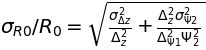

In [30]:
_u_r = Eq(_uncer_r.rhs,sqrt((delta_z/delta_psi1)**2*(sigma_Psi2**2/psi_2**2) + (sigma_dz**2/delta_z**2)))
_u_r

The uR0 is dominated by the displacement uncertainty.

In [31]:
_u = []
for i in range(1,4):
    num = (((_d_z[i]/(_psi1[i]-_psi1[0]))**2)*(((1e-06)**2)/(_psi2[0])**2)+((10e-6)**2/(_d_z[i])**2))**(1/2)
    _u.append(num)
    print(_u[i-1].real)
#_u

0.3085641516571783
0.3091662391647922
0.30971251328020666


#### The uncertainty on Acm is derived from:

In [32]:
_uncer_a = Eq(u_am, sigma_acm/A_cm)
_uncer_a

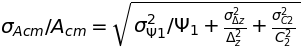

In [33]:
_u_a = Eq(_uncer_a.rhs, sqrt((sigma_dz)**2/(delta_z)**2 + (sigma_c2)**2/(C2)**2 + (sigma_Psi1)**2/psi_1))
_u_a

In [34]:
_uacm = []
for i in range(1,4):
    value = sqrt((1e-06**2/_psi1[i].real)+(10e-6**2/(_d_z[i])**2)+((100/1E+6)**2/_C2[i].real**2))
    _uacm.append(value)
_uacm

#### The uncertainty on Kn is derived from:

In [35]:
_uncer_kn = Eq(u_kn,sigma_kn/kappa_n)
_uncer_kn

In [36]:
_u_kn = Eq(_uncer_kn.rhs, n*((sigma_r0/R_0) + (sigma_acm/(2*A_cm))))
_u_kn

In [37]:
def uncertainty_kn(n):
    array = []
    for i in range(1,4):
        value = n*(_u[i-1].real + (_uacm[i-1]/2))
        array.append(value)
    return array

In [38]:
_uncer_kn_1 = uncertainty_kn(1)
_uncer_kn_2 = uncertainty_kn(2)

In [39]:
_uncer_kn_1

In [40]:
_uncer_kn_2